In [37]:
import sys
import os
sys.path.append(os.path.abspath('/Users/ericxia/school/Math-148-Project/food-classification'))

from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader

from data_utils.utils import keep_existing_photos, downsample_group
from data_utils.dataset import PhotoLabelDataset, stratified_split_dataset
from model.resnet18 import Resnet18FineTuneModel
from model.utils import get_device
from model.gradcam import GradCAM

### Binary prediction model single modality

In [7]:
base_dir = "../"

business_df = pd.read_json(f'{base_dir}data/yelp_dataset/yelp_academic_dataset_business.json', lines=True)
photos_df = pd.read_json(f'{base_dir}data/yelp_photos/photos.json', lines=True)
top_reviews_per_restaurant = pd.read_csv(f'{base_dir}data/yelp_dataset/top_reviews_per_restaurant_with_summary.csv')

photo_dir = f"{base_dir}data/yelp_photos/resized_photos"
photos_df = keep_existing_photos(photos_df, photo_dir)

photos_df = photos_df[photos_df['label'] == 'food'].copy()

categories_df = business_df[['business_id', 'attributes']].copy()
photos_df = photos_df.merge(categories_df, on="business_id", how="left")

photos_df = photos_df[photos_df['attributes'].notna()]
photos_df['price_range'] = photos_df['attributes'].apply(lambda x: x.get('RestaurantsPriceRange2'))

photos_df['price_range'] = photos_df['price_range'].astype(int)
photos_df['price_range'] = photos_df['price_range'].replace({2: 1, 3: 2, 4: 2}) 

food_with_reviews_df = photos_df.merge(top_reviews_per_restaurant, on="business_id", how="left")

Checking images: 100%|██████████| 200100/200100 [00:12<00:00, 15848.80it/s]


In [9]:
price_2_num = (photos_df.price_range == 2).sum()

food_df = photos_df.groupby('price_range', group_keys=False).apply(
    lambda x: downsample_group(x, price_2_num) if x.name in [1] else x  # Only downsample for price_range 1 and 2
)

food_df['price_range'] = food_df['price_range'] - 1

/var/folders/6n/sm2tfzkn2hjd8cpfn_256ph00000gp/T/ipykernel_22839/634064193.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  food_df = photos_df.groupby('price_range', group_keys=False).apply(


In [14]:
label = 'price_range'

val_transform = transforms.Compose([
     transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
price_dataset = PhotoLabelDataset(food_df, photo_dir, label)
labels = food_df[label].values 
train_size = 0.85
val_size = 0.10

_, _, test_dataset = stratified_split_dataset(
    price_dataset,
    labels,
    train_size=train_size,
    val_size=val_size,
    random_state=42
)

test_dataset.transform = val_transform

batch_size = 64

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [15]:
num_classes = 2
device = get_device()

binary_image_only = Resnet18FineTuneModel(num_classes=num_classes)

price_ckpt_19 = torch.load("../checkpoints/price_2_classes/ckpt_1")
binary_image_only.load_state_dict(price_ckpt_19['model_state_dict'])
binary_image_only.to(device)
binary_image_only.eval()

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet18FineTuneModel(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [18]:
all_class_0 = []
all_class_1 = []
all_conf = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        outputs = binary_image_only(images)
        probs = F.softmax(outputs, dim=1)

        max_conf, pred_classes = torch.max(probs, dim=1)

        for i in range(len(images)):
            conf = max_conf[i].item()
            pred_class = pred_classes[i].item()
            sample = (conf, images[i])

            if pred_class == 0:
                all_class_0.append(sample)
            elif pred_class == 1:
                all_class_1.append(sample)

            all_conf.append(sample)

In [29]:
top_5_class_0 = sorted(all_class_0, key=lambda x: x[0], reverse=True)[12:17]
top_5_class_1 = sorted(all_class_1, key=lambda x: x[0], reverse=True)[5:10]
bottom_5_conf = sorted(all_conf, key=lambda x: x[0])[:5]

In [27]:
def show_images(samples, title):
    fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))
    for ax, (conf, img) in zip(axes, samples):
        img = img.cpu().numpy().transpose(1, 2, 0)  # Convert tensor to NumPy
        ax.imshow(img)
        ax.set_title(f"Conf: {conf:.4f}")
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

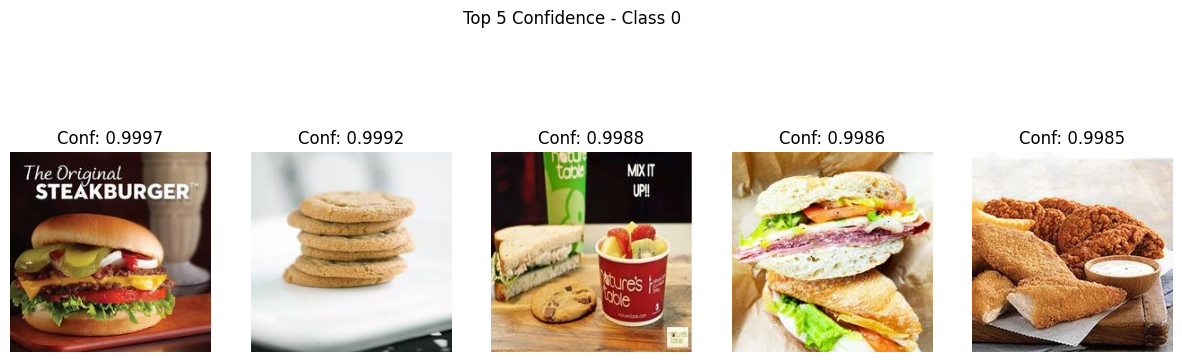

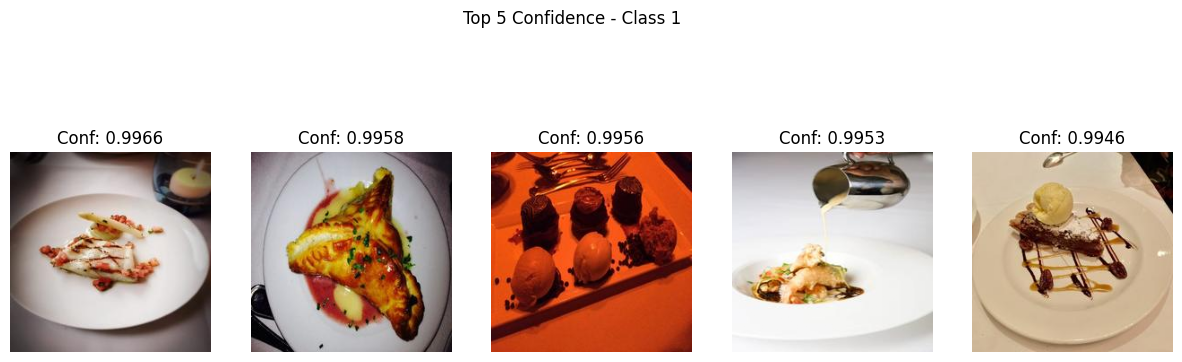

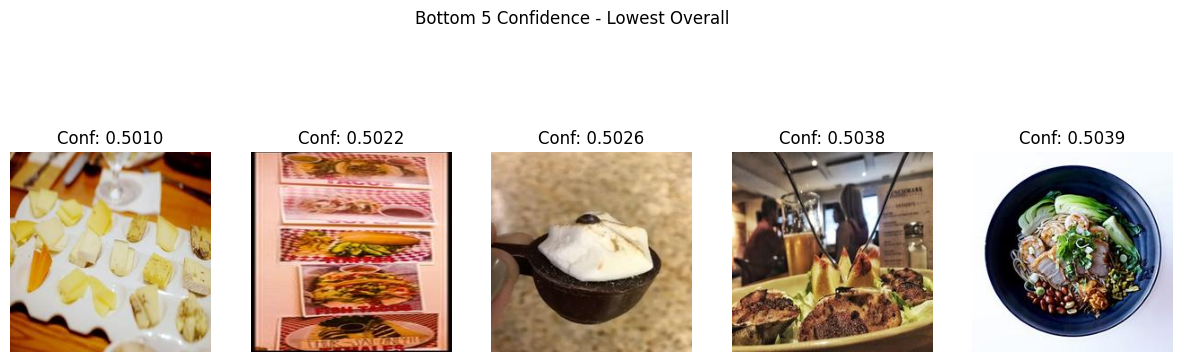

In [30]:
if top_5_class_0:
    show_images(top_5_class_0, "Top 5 Confidence - Class 0")
if top_5_class_1:
    show_images(top_5_class_1, "Top 5 Confidence - Class 1")
if bottom_5_conf:
    show_images(bottom_5_conf, "Bottom 5 Confidence - Lowest Overall")

In [51]:
food_with_reviews_df[food_with_reviews_df['photo_id'] == "n8PcPp6Xyr26KwV06c3XNQ"]

,photo_id,business_id,caption,label,attributes,price_range,text,summary
96925,n8PcPp6Xyr26KwV06c3XNQ,k1WPGl766RE5t42kD60RyQ,Limoncello cake,food,"{'BusinessParking': '{'garage': False, 'street...",1,Just went to an empty restaurant with a Groupo...,Luigi's is on their game but being Valentine'...


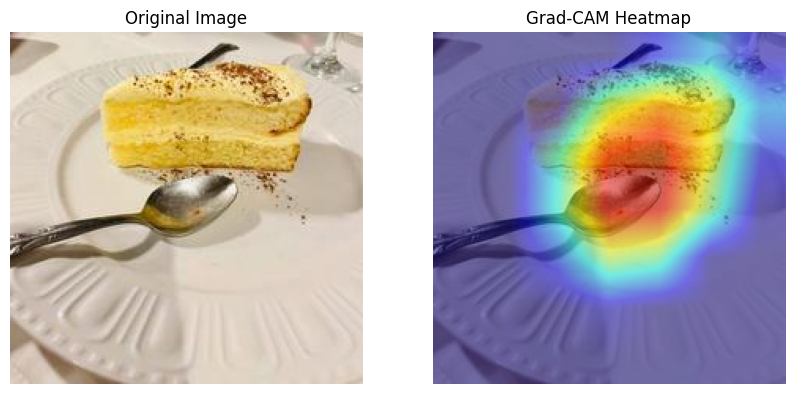

In [ ]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    return image, input_tensor


image_path = f"{base_dir}data/yelp_photos/resized_photos/n8PcPp6Xyr26KwV06c3XNQ.jpg"
original_image, input_tensor = preprocess_image(image_path)
input_tensor = input_tensor.to(device)

target_layer = binary_image_only.base.layer4[1] 

gradcam = GradCAM(binary_image_only, target_layer)

cam = gradcam.generate_cam(input_tensor)

original_image_np = np.array(original_image)

overlay_image = gradcam.overlay_heatmap(original_image_np, cam)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_image_np)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(overlay_image)
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis("off")

plt.show()